<a href="https://colab.research.google.com/github/ashish-y/google-colab-transfer-learning/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file = "dataset.zip"

with ZipFile(file, 'r') as zip:
  zip.extractall()
  print('Done')


Done


In [27]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf 
print(tf.__version__);
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
import tensorflow.keras as keras
keras.__version__

2.3.0
Default GPU Device:/device:GPU:0


'2.4.0'

In [28]:
import tensorflow.keras

In [29]:
#import tfkeras as ef
import tensorflow.keras.applications.efficientnet as ef
#import tensorflow.keras.applications.efficientnet as ef

In [30]:
input_size = 150

In [31]:
base_model =  ef.EfficientNetB7(input_shape=(input_size, input_size, 3), weights='imagenet',include_top=False)
#for layer in base_model.layers:
#    layer.trainable = False
x = tensorflow.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tensorflow.keras.layers.Dense(3, activation='softmax')(x)
Model = tensorflow.keras.models.Model(inputs=[base_model.input], outputs=[output])

In [32]:
Model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 150, 150, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 150, 150, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_3[0][0]            
_______________________________________________________________________________________

In [33]:
from tensorflow.keras import optimizers

In [34]:
#optim = optimizers.Nadam(lr=0.001,clipnorm=1)
optim = optimizers.Nadam(lr=0.00001)

In [35]:
from tensorflow.keras import backend as K
def F1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (predicted_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [36]:
Model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = './dataset/train'
valid_path = './dataset/validation'
test_path = './dataset/test'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')
print(training_set.class_indices)
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (input_size, input_size),
                                            batch_size = 4,
                                            class_mode = 'categorical')
print(test_set.class_indices)

Found 168 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}
Found 52 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}


In [38]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model_B7_v3.h5', monitor="val_loss", verbose=1,
                                             save_best_only=True, save_weights_only=False, mode="min")
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy')>0.96):
            print("Reached 96% accuracy so cancelling training!")
            self.model.stop_training=True
callbacks = myCallback()

In [40]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
history = Model.fit( training_set, validation_data=test_set, epochs=100, 
                    steps_per_epoch=len(training_set), validation_steps=len(test_set),
                   callbacks=[checkpoint])

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.0594 - accuracy: 0.4762

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00001: val_loss improved from inf to 1.10631, saving model to best_model_B7_v3.h5
42/42 [==============================] - 33s 789ms/step - loss: 1.0594 - accuracy: 0.4762 - val_loss: 1.1063 - val_accuracy: 0.4038
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.6548
Epoch 00002: val_loss improved from 1.10631 to 1.10628, saving model to best_model_B7_v3.h5
42/42 [==============================] - 28s 668ms/step - loss: 0.9417 - accuracy: 0.6548 - val_loss: 1.1063 - val_accuracy: 0.4038
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.7619
Epoch 00003: val_loss improved from 1.10628 to 1.10309, saving model to best_model_B7_v3.h5
42/42 [==============================] - 29s 684ms/step - loss: 0.8348 - accuracy: 0.7619 - val_loss: 1.1031 - val_accuracy: 0.4038
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.7857
Epoch 00004: val_loss did not improve from 1.1

In [41]:
Model.save_weights('model_weights.h5')
Model.save('model.h5')
print("model saved")

model saved


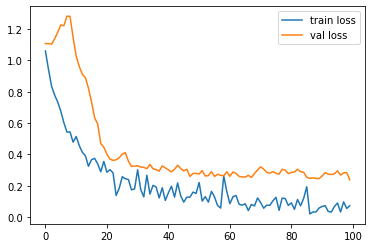

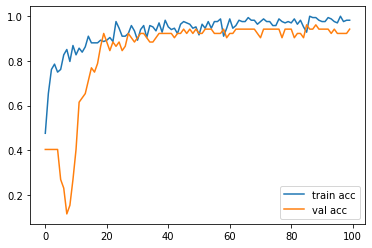

KeyError: ignored

In [42]:
# loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

# F1 score
plt.plot(history.history['F1_score'], label='train F1')
plt.plot(history.history['val_F1_score'], label='val F1')
plt.legend()
plt.show()
# plt.savefig('F1Val_F1')

In [63]:
#prediction
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
loaded_model = load_model('best_model_B7_v3.h5')
path="c_3.png"
img_pred = image.load_img(path, target_size=(150, 150))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)
#images = np.vstack([img_pred])
rslt = loaded_model.predict(img_pred)
print(rslt)
print(np.argmax(rslt))
if np.argmax(rslt) == 0:
  print("Close")
if np.argmax(rslt) == 1:
  print("Open")
else:
  print("Unknown")

[[9.9928135e-01 7.1864791e-04 2.5122374e-10]]
0
Close
Unknown
